In [1]:
# Needed for successful imports
%cd ../..

c:\Users\zach_\VSCode Projects\DLProject


c:\Users\zach_\VSCode Projects\DLProject\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy
from tqdm.notebook import tqdm

from src.Dataset import CustomDataset
from src.TrainHelpers import plot_loss_graph, encode_data, train_svm
from src.TestHelpers import test_model, calculate_accuracy

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps") 
else:
    device = torch.device("cpu")
print(device)

cuda


In [2]:
### PARAMETERS ###
dataset_ver = '3w05s_Larm'
n_input = 9
n_hidden = 360
early_stop = True
patience = 5
dropout_rate = 0.2
num_epochs = 50
lr_rate = 1e-3
seed = 345

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

x_train = np.load(f'input/train_data_{dataset_ver}.npy')
x_val = np.load(f'input/val_data_{dataset_ver}.npy')
x_test = np.load(f'input/test_data_{dataset_ver}.npy')

y_train = np.load(f'input/train_labels_{dataset_ver}.npy')
y_val = np.load(f'input/val_labels_{dataset_ver}.npy')
y_test = np.load(f'input/test_labels_{dataset_ver}.npy')

(11578, 60, 9) (3308, 60, 9) (1654, 60, 9)


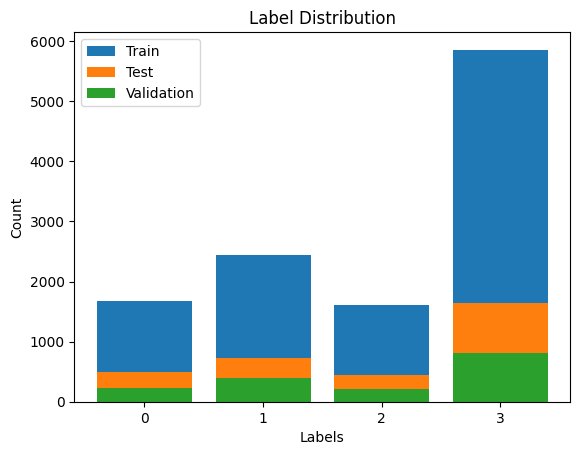

In [3]:
# Check Dataset
print(x_train.shape, x_test.shape, x_val.shape)
unique_labels_train, label_counts_train = np.unique(y_train, return_counts=True)
unique_labels_val, label_counts_val = np.unique(y_val, return_counts=True)
unique_labels_test, label_counts_test = np.unique(y_test, return_counts=True)

plt.bar(unique_labels_train, label_counts_train, label='Train')
plt.bar(unique_labels_test, label_counts_test, label='Test')
plt.bar(unique_labels_val, label_counts_val, label='Validation')

# Set the x-axis tick labels
plt.xticks(unique_labels_train, unique_labels_train)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.legend()
plt.show()

In [4]:
### Declare Dataloaders
train_dataset = CustomDataset("train", dataset_ver)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = CustomDataset("val", dataset_ver)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataset = CustomDataset("test", dataset_ver)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [5]:
# 1-Layer CNN + 1-Layer Bidirectional LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(Encoder, self).__init__()
        nb_filters = 64
        self.conv = nn.Conv1d(input_size, nb_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.LSTM1 = nn.LSTM(nb_filters, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_size = hidden_size

    def forward(self, x):
        x = x.permute(0, 2, 1)  # conv = (batch, no of channels, sequence length)
        x = self.conv(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # swap back
        x, (encoded_x, _) = self.LSTM1(x)
        x = self.dropout(encoded_x)
        return x[-1,:,:]

class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Decoder, self).__init__()
        nb_filters = 64
        self.hidden_size = hidden_size
        self.conv = nn.Conv1d(hidden_size, nb_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.LSTM1 = nn.LSTM(nb_filters, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x = x.permute(0, 2, 1)  # conv = (batch, no of channels, sequence length)
        x = self.conv(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # swap back
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size, dropout_rate).to(device)
        self.decoder = Decoder(hidden_size, in_out_size, dropout_rate).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential()

        for i in range(len(layer_sizes)-1):
            self.mlp.add_module(f'fc{i+1}', nn.Linear(layer_sizes[i], layer_sizes[i+1]))

    def forward(self, x):
        return self.mlp(x)

In [7]:
tag = '1CNN_1LSTMBD'
encoder_ver = f'{n_hidden}h{num_epochs}e{dropout_rate}dr{lr_rate}lr'
# train_losses, val_losses = train_model(Autoencoder, train_dataloader, val_dataloader, val_dataset, n_input, n_hidden, dataset_ver, encoder_ver, tag, early_stop, dropout_rate, num_epochs, lr_rate)
# plot_loss_graph(train_losses, val_losses, tag)
encoded_train_data, train_labels = encode_data(train_dataloader, dataset_ver, tag, encoder_ver)
encoded_val_data, val_labels = encode_data(val_dataloader, dataset_ver, tag, encoder_ver)
encoded_test_data, test_labels = encode_data(test_dataloader, dataset_ver, tag, encoder_ver)

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Loading Encoder Model...
Encoding Data...


  0%|          | 0/104 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([1654, 360])
labels.shape=torch.Size([1654, 1])
Loading Encoder Model...
Encoding Data...


  0%|          | 0/207 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([3308, 360])
labels.shape=torch.Size([3308, 1])


Training SVM Classifier...
Accuracy: 0.961139896373057


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 97.22%


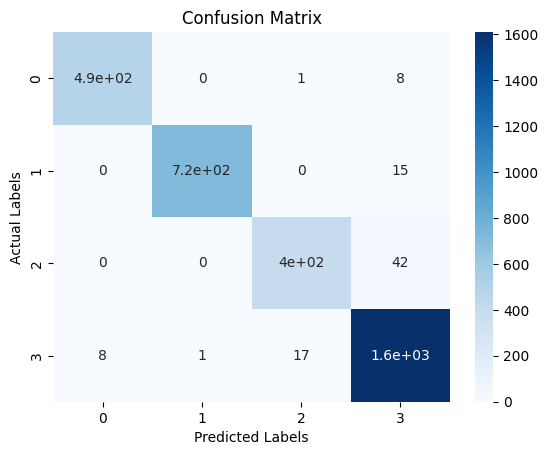

In [8]:
svm_classifier = train_svm(encoded_train_data, train_labels.ravel(), dataset_ver, tag, encoder_ver)
### Streamlined testing of model + SVM ###
test_labels, test_predictions = test_model(test_dataloader, dataset_ver, tag, encoder_ver)
calculate_accuracy(test_labels, test_predictions, tag)

In [9]:
encoded_dataset_train = TensorDataset(encoded_train_data, train_labels)
encoded_dataloader_train = DataLoader(encoded_dataset_train, batch_size=1, shuffle=True)

encoded_dataset_val = TensorDataset(encoded_val_data, val_labels)
encoded_dataloader_val = DataLoader(encoded_dataset_val, batch_size=1, shuffle=True)

encoded_dataset_test = TensorDataset(encoded_test_data, test_labels)
encoded_dataloader_test = DataLoader(encoded_dataset_test, batch_size=1, shuffle=True)

In [10]:
def train_MLP(model, enc_dtl_train, enc_dtl_val, learning_rate, num_epochs, patience, tag):
    optimizer = optim.Adam(model.parameters(),
                            lr=learning_rate,
                            betas=(0.9, 0.999),
                            eps=1e-8)

    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    best_val_loss = np.inf
    es_count = 0

    for epoch in range(num_epochs):
        if es_count < patience:
            print(f'Starting Epoch {epoch+1}...')
            model.train()

            train_preds = []
            train_labels = []

            correct_train = 0
            total_train = 0

            train_loss = 0
            for train_X, train_y in tqdm(enc_dtl_train):
                optimizer.zero_grad()
                
                train_output = model(train_X)
                
                train_criterion = criterion(train_output, train_y[0].type(torch.LongTensor))
                train_criterion.backward()
                train_loss += train_criterion.item()
                optimizer.step()

                train_preds.append(torch.argmax(train_output))
                train_labels.append(train_y)

                if train_preds[-1] == train_labels[-1]:
                    correct_train += 1
                total_train += 1

            model.eval()

            val_preds = []
            val_labels = []

            correct_val = 0
            total_val = 0

            val_loss = 0
            for val_X, val_y in tqdm(enc_dtl_val):
                val_output = model(val_X)

                val_preds.append(torch.argmax(val_output))
                val_labels.append(val_y)

                val_criterion = criterion(val_output, val_y[0].type(torch.LongTensor))
                val_loss += val_criterion.item()

                if val_preds[-1] == val_labels[-1]:
                    correct_val += 1
                total_val += 1

            train_losses.append(train_loss / len(enc_dtl_train))
            print(f'Train Loss = {train_losses[-1]}')

            train_acc = (correct_train / total_train) * 100
            print(f'Train Acc = {train_acc}')

            val_losses.append(val_loss / len(enc_dtl_val))
            print(f'Val Loss = {val_losses[-1]}')

            val_acc = (correct_val / total_val) * 100
            print(f'Val Acc = {val_acc}')

            if val_losses[-1] < best_val_loss:
                torch.save(deepcopy(model.state_dict()), f'models/MLP_{tag}.pt')
                best_val_loss = val_losses[-1]
                es_count = 0
                continue
            
            es_count += 1
        
        else:
            print('Early Stopping...')
            break
    
    return train_losses, val_losses

MLP(
  (mlp): Sequential(
    (fc1): Linear(in_features=360, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=4, bias=True)
  )
)
Starting Epoch 1...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.3242947248392657
Train Acc = 88.21903610295388
Val Loss = 0.2427522222005228
Val Acc = 91.11245465538089
Starting Epoch 2...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.23786104184269868
Train Acc = 91.61340473311452
Val Loss = 0.23206458866974075
Val Acc = 91.492485748834
Starting Epoch 3...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.21186409698699527
Train Acc = 92.45983762307826
Val Loss = 0.18818897569835014
Val Acc = 93.48764898946278
Starting Epoch 4...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.19988534815724265
Train Acc = 92.86577992744861
Val Loss = 0.180031228994162
Val Acc = 93.3580929348765
Starting Epoch 5...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.18405865339991823
Train Acc = 93.38400414579374
Val Loss = 0.16588009146488886
Val Acc = 93.92813957505614
Starting Epoch 6...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.1784000362624054
Train Acc = 93.81585766108135
Val Loss = 0.1598606388357731
Val Acc = 93.96268785627915
Starting Epoch 7...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.1730397609394059
Train Acc = 93.64311625496632
Val Loss = 0.14433488089386248
Val Acc = 94.81775781654864
Starting Epoch 8...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.16567340008848855
Train Acc = 93.83313180169287
Val Loss = 0.1499009073032676
Val Acc = 94.6968388322681
Starting Epoch 9...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.15661415769506698
Train Acc = 94.29953359820348
Val Loss = 0.1415170052890381
Val Acc = 94.9300397305234
Starting Epoch 10...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.15751633439040308
Train Acc = 94.00587320780791
Val Loss = 0.14663945550258534
Val Acc = 94.37726723095527
Starting Epoch 11...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.1532399481658481
Train Acc = 94.43772672309552
Val Loss = 0.13874840109933367
Val Acc = 95.04232164449819
Starting Epoch 12...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.14972404365053738
Train Acc = 94.40317844187251
Val Loss = 0.1332597248865938
Val Acc = 95.36189324581102
Starting Epoch 13...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.1442114131593616
Train Acc = 94.85230609777163
Val Loss = 0.12421472343674782
Val Acc = 95.70737605804112
Starting Epoch 14...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.14180465815100962
Train Acc = 94.77457246501987
Val Loss = 0.14252343161090394
Val Acc = 94.93867680082916
Starting Epoch 15...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.13951789213883345
Train Acc = 94.88685437899464
Val Loss = 0.1293372077177681
Val Acc = 95.33598203489376
Starting Epoch 16...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.1382087065068915
Train Acc = 94.91276558991191
Val Loss = 0.13904949945085074
Val Acc = 94.80912074624287
Starting Epoch 17...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.13510971367206961
Train Acc = 94.94731387113491
Val Loss = 0.13885471155438492
Val Acc = 94.88685437899464
Starting Epoch 18...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.1341906183940609
Train Acc = 94.95595094144066
Val Loss = 0.11588100940766406
Val Acc = 95.8369321126274
Starting Epoch 19...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.13014504973302538
Train Acc = 95.31007082397652
Val Loss = 0.137262228146217
Val Acc = 94.82639488685439
Starting Epoch 20...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.1281751887888172
Train Acc = 95.4914493003973
Val Loss = 0.11085126151465512
Val Acc = 96.16514078424598
Starting Epoch 21...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.1279929765794238
Train Acc = 95.52599758162032
Val Loss = 0.1202522978914949
Val Acc = 95.34461910519951
Starting Epoch 22...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.12632835268735476
Train Acc = 95.42235273795129
Val Loss = 0.11576217025406497
Val Acc = 95.90602867507342
Starting Epoch 23...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.12711684802682904
Train Acc = 95.37916738642252
Val Loss = 0.11218929038455513
Val Acc = 96.13059250302297
Starting Epoch 24...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.12416427358303286
Train Acc = 95.4741751597858
Val Loss = 0.13251544811056185
Val Acc = 95.05095871480394
Starting Epoch 25...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.12326693577946045
Train Acc = 95.63827949559509
Val Loss = 0.1047760731367702
Val Acc = 96.45880117464156
Starting Epoch 26...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.12158928526871095
Train Acc = 95.6210053549836
Val Loss = 0.10851552232266248
Val Acc = 96.234237346692
Starting Epoch 27...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.11826427711753698
Train Acc = 95.6555536362066
Val Loss = 0.11060572089720129
Val Acc = 95.75056140956988
Starting Epoch 28...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.11723279925844186
Train Acc = 95.63827949559509
Val Loss = 0.10602259057621223
Val Acc = 96.13059250302297
Starting Epoch 29...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.11777413460433463
Train Acc = 95.77647262048713
Val Loss = 0.11568577552396524
Val Acc = 95.72465019865261
Starting Epoch 30...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.11681917098590433
Train Acc = 95.79374676109863
Val Loss = 0.09625635345898605
Val Acc = 96.5969942995336
Starting Epoch 31...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.11726002280633906
Train Acc = 95.73328726895836
Val Loss = 0.1191386771487817
Val Acc = 95.50872344100881
Starting Epoch 32...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.11409148193850226
Train Acc = 96.02694765935395
Val Loss = 0.10210288626331258
Val Acc = 96.46743824494732
Starting Epoch 33...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.11557725705086638
Train Acc = 95.8023838314044
Val Loss = 0.0941046165897983
Val Acc = 96.70927621350837
Starting Epoch 34...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.11326593034792412
Train Acc = 95.92330281568492
Val Loss = 0.11682537111900078
Val Acc = 95.84556918293315
Starting Epoch 35...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.1133873765282321
Train Acc = 95.84556918293315
Val Loss = 0.10758575460973403
Val Acc = 95.97512523751944
Starting Epoch 36...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.11151872538750335
Train Acc = 95.91466574537917
Val Loss = 0.10932514443366877
Val Acc = 96.22560027638625
Starting Epoch 37...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.11173092084239689
Train Acc = 96.13059250302297
Val Loss = 0.1053327079794486
Val Acc = 96.04422179996546
Starting Epoch 38...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.1076952444342718
Train Acc = 96.07013301088271
Val Loss = 0.12099853747629705
Val Acc = 95.79374676109863
Early Stopping...


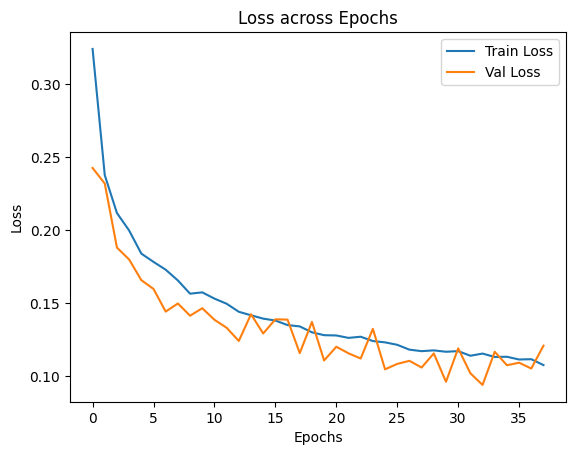

In [11]:
mlp_classifier_1 = MLP([360, 64, 16, 4])
tag = f'MLP_{dataset_ver}_360-64-16-4'
print(mlp_classifier_1)
train_losses, val_losses = train_MLP(mlp_classifier_1, encoded_dataloader_train, encoded_dataloader_train, 1e-3, 50, 5, tag)
plot_loss_graph(train_losses, val_losses, tag)

MLP(
  (mlp): Sequential(
    (fc1): Linear(in_features=360, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=4, bias=True)
  )
)
Starting Epoch 1...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.32447749477849064
Train Acc = 87.92537571255829
Val Loss = 0.276344081570035
Val Acc = 89.48004836759371
Starting Epoch 2...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.24237667958424902
Train Acc = 91.19882535843841
Val Loss = 0.21661583077220561
Val Acc = 91.85524270167559
Starting Epoch 3...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.21903628522868418
Train Acc = 92.24391086543444
Val Loss = 0.2256866813838122
Val Acc = 91.51839695975124
Starting Epoch 4...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.2020739529288203
Train Acc = 92.57211953705303
Val Loss = 0.17015420122541747
Val Acc = 93.81585766108135
Starting Epoch 5...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.19183902052594484
Train Acc = 92.96078770081189
Val Loss = 0.17201300833158356
Val Acc = 93.63447918466056
Starting Epoch 6...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.1836774086256029
Train Acc = 93.45310070823977
Val Loss = 0.1558760460684336
Val Acc = 94.3340818794265
Starting Epoch 7...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.17195446564906877
Train Acc = 93.74676109863535
Val Loss = 0.1812782947274405
Val Acc = 93.40127828640526
Starting Epoch 8...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.16814959765335435
Train Acc = 93.8244947313871
Val Loss = 0.16461239492925944
Val Acc = 93.62584211435481
Starting Epoch 9...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.16420588077018525
Train Acc = 93.9713249265849
Val Loss = 0.15181071663559806
Val Acc = 94.07496977025393
Starting Epoch 10...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.16026325768798358
Train Acc = 94.08360684055968
Val Loss = 0.1524467882916794
Val Acc = 94.28225945759199
Starting Epoch 11...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.1555311238131752
Train Acc = 94.28225945759199
Val Loss = 0.13830015265651577
Val Acc = 94.94731387113491
Starting Epoch 12...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.15078794518498678
Train Acc = 94.47227500431853
Val Loss = 0.12672936577601726
Val Acc = 95.52599758162032
Starting Epoch 13...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.14821777931164523
Train Acc = 94.45500086370703
Val Loss = 0.15331358897736347
Val Acc = 93.9885990671964
Starting Epoch 14...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.14653111870698282
Train Acc = 94.6968388322681
Val Loss = 0.12988368359319655
Val Acc = 95.28415961305924
Starting Epoch 15...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.14318362223861344
Train Acc = 94.73138711349111
Val Loss = 0.11873009955449934
Val Acc = 95.99239937813093
Starting Epoch 16...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.14062724980722416
Train Acc = 95.06823285541545
Val Loss = 0.13110822677996228
Val Acc = 95.0941440663327
Starting Epoch 17...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.13698408665499132
Train Acc = 95.22370012091899
Val Loss = 0.1291500506696196
Val Acc = 95.40507859733978
Starting Epoch 18...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.13589618475710832
Train Acc = 95.10278113663844
Val Loss = 0.12103683147643082
Val Acc = 95.41371566764553
Starting Epoch 19...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.1344289643690737
Train Acc = 95.04232164449819
Val Loss = 0.13564746417529253
Val Acc = 95.17187769908448
Starting Epoch 20...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.131428277743451
Train Acc = 95.27552254275349
Val Loss = 0.15261374744339998
Val Acc = 93.89359129383314
Early Stopping...


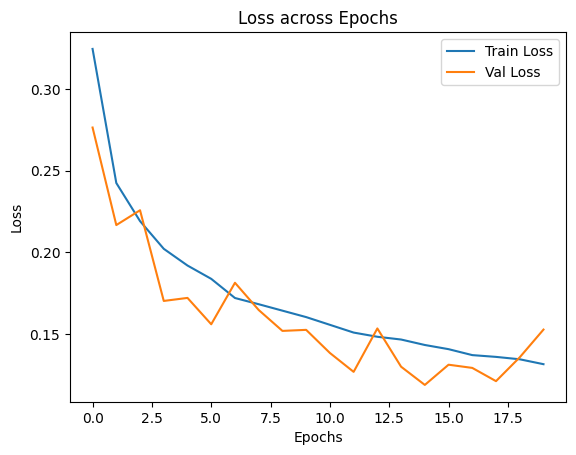

In [12]:
mlp_classifier_2 = MLP([360, 128, 32, 4])
tag = f'MLP_{dataset_ver}_360-128-32-4'
print(mlp_classifier_2)
train_losses, val_losses = train_MLP(mlp_classifier_2, encoded_dataloader_train, encoded_dataloader_train, 1e-3, 50, 5, tag)
plot_loss_graph(train_losses, val_losses, tag)

MLP(
  (mlp): Sequential(
    (fc1): Linear(in_features=360, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=4, bias=True)
  )
)
Starting Epoch 1...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.33510434535523964
Train Acc = 88.09811711867334
Val Loss = 0.2300578427137771
Val Acc = 92.15754016237692
Starting Epoch 2...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.22826970449347045
Train Acc = 91.78614613922957
Val Loss = 0.19861805568452615
Val Acc = 93.07306961478666
Starting Epoch 3...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.20587908542519345
Train Acc = 92.77077215408534
Val Loss = 0.18529454400783363
Val Acc = 93.46173777854551
Starting Epoch 4...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.1877751583035413
Train Acc = 93.31490758334773
Val Loss = 0.17783848009288392
Val Acc = 93.34945586457074
Starting Epoch 5...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.17824533857296407
Train Acc = 93.55674555190879
Val Loss = 0.15451193330242757
Val Acc = 94.61910519951633
Starting Epoch 6...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.16976670568821636
Train Acc = 93.85904301261012
Val Loss = 0.1486162969096866
Val Acc = 94.40317844187251
Starting Epoch 7...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.16417573414403672
Train Acc = 94.26498531698047
Val Loss = 0.14038427138898626
Val Acc = 95.05095871480394
Starting Epoch 8...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.156012187873607
Train Acc = 94.3340818794265
Val Loss = 0.14966323518341682
Val Acc = 94.58455691829332
Starting Epoch 9...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.1509423167394751
Train Acc = 94.56728277768181
Val Loss = 0.1311992789785474
Val Acc = 95.31870789428226
Starting Epoch 10...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.14979310188187017
Train Acc = 94.50682328554154
Val Loss = 0.12972608308141287
Val Acc = 95.43962687856279
Starting Epoch 11...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.14578935852889488
Train Acc = 94.71411297287959
Val Loss = 0.1300207970873171
Val Acc = 95.1459664881672
Starting Epoch 12...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.14275750772259285
Train Acc = 94.7486612541026
Val Loss = 0.13689844415990213
Val Acc = 95.31007082397652
Starting Epoch 13...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.13820644713820185
Train Acc = 94.96458801174641
Val Loss = 0.11911584562726663
Val Acc = 95.88875453446191
Starting Epoch 14...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.1362076213513328
Train Acc = 95.12005527724996
Val Loss = 0.12279941211040099
Val Acc = 95.68146484712385
Starting Epoch 15...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.13288181262238472
Train Acc = 94.96458801174641
Val Loss = 0.13236667268999996
Val Acc = 94.79184660563136
Starting Epoch 16...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.1304197750694057
Train Acc = 95.18915183969597
Val Loss = 0.11871162017691321
Val Acc = 95.95785109690793
Starting Epoch 17...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.12879218804346346
Train Acc = 95.43962687856279
Val Loss = 0.1116062582168655
Val Acc = 96.15650371394024
Starting Epoch 18...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.12968166810378498
Train Acc = 95.20642598030747
Val Loss = 0.11827720491746933
Val Acc = 95.57782000345483
Starting Epoch 19...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.12659612984910146
Train Acc = 95.35325617550527
Val Loss = 0.11213545430013527
Val Acc = 96.0010364484367
Starting Epoch 20...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.12352229129961752
Train Acc = 95.55190879253757
Val Loss = 0.11287207037233415
Val Acc = 95.79374676109863
Starting Epoch 21...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.12249107643060274
Train Acc = 95.50008637070306
Val Loss = 0.10582889069762624
Val Acc = 96.26014855760926
Starting Epoch 22...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.12102336188248057
Train Acc = 95.81965797201589
Val Loss = 0.11365305481444903
Val Acc = 95.66419070651236
Starting Epoch 23...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.12100985923589531
Train Acc = 95.56918293314908
Val Loss = 0.10792690400284909
Val Acc = 96.05285887027121
Starting Epoch 24...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.11731968274602049
Train Acc = 95.77647262048713
Val Loss = 0.12835297856186587
Val Acc = 95.32734496458801
Starting Epoch 25...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.11820901937231844
Train Acc = 95.78510969079288
Val Loss = 0.10069296541227443
Val Acc = 96.5969942995336
Starting Epoch 26...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.11810841486104655
Train Acc = 95.73328726895836
Val Loss = 0.10838467847187214
Val Acc = 95.95785109690793
Starting Epoch 27...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.11406462943158323
Train Acc = 95.8542062532389
Val Loss = 0.10691432833740029
Val Acc = 96.00967351874245
Starting Epoch 28...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.11318105616126845
Train Acc = 95.95785109690793
Val Loss = 0.10364698773887877
Val Acc = 96.2515114873035
Starting Epoch 29...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.11391914151785242
Train Acc = 95.81102090171014
Val Loss = 0.10231051741382247
Val Acc = 96.33788219036103
Starting Epoch 30...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.11103072218922568
Train Acc = 96.06149594057696
Val Loss = 0.11243765500463752
Val Acc = 95.89739160476766
Early Stopping...


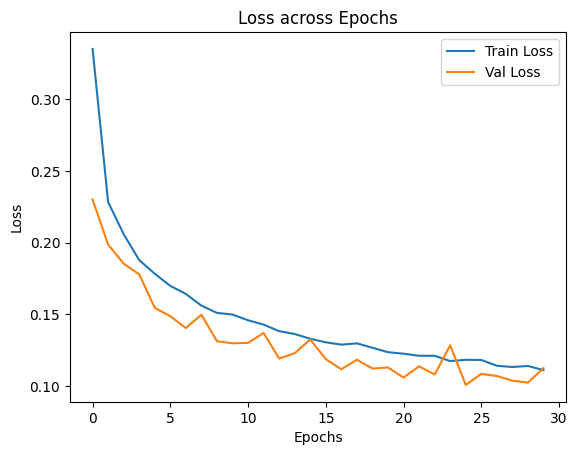

In [13]:
mlp_classifier_3 = MLP([360, 64, 4])
tag = f'MLP_{dataset_ver}_360-64-4'
print(mlp_classifier_3)
train_losses, val_losses = train_MLP(mlp_classifier_3, encoded_dataloader_train, encoded_dataloader_train, 1e-3, 50, 5, tag)
plot_loss_graph(train_losses, val_losses, tag)